# General Deep Image Completion with LC GAN

In [ ]:
import random

import numpy as np

import tensorflow as tf

import matplotlib.pyplot as plt

from masks import *

In [ ]:
IMAGE_SIZE = (32, 32)

## Build the generator

### Build semantic feature extraction (Encoder)

**Semantic Feature Extractor**: Given a corrupted image I with size H × W as input, we use a part of layers (before conv4-1) from VGG19 architecture as our semantic feature extractor (encoder) to obtain a high-level and semantic feature patch. To preserve image details, we replace all the pooling layer with strided convolutions as the pooling layer tens to lose some information in the reconstruction based networks. Also, we decrease the filter numbers of each layer to reduce the total model size.
Each convolution is followed by ELU activation that enhances the performance of the autoencoder.

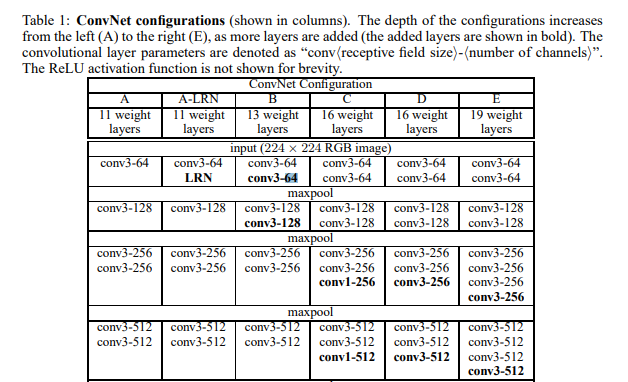

In [ ]:
class SemanticFeatureExtractor(tf.keras.Model):
    def __init__(self):
        super(SemanticFeatureExtractor, self).__init__(name = 'SemanticFeatureExtractor')
        # Building table 1 VGG19 column B model's architecture
        
        # Row 1
        self.conv_3_32_1 = tf.keras.layers.Conv2D(32, kernel_size=3, padding='same')
        self.elu_1_1 = tf.keras.layers.ELU()

        self.conv_3_32_2 = tf.keras.layers.Conv2D(32, kernel_size=3, padding='same')
        self.elu_1_2 = tf.keras.layers.ELU()
        
        self.strided_conv_1 = tf.keras.layers.Conv2D(32, kernel_size=3, strides=2, padding='same')
        
        # Row 2
        self.conv_3_64_1 = tf.keras.layers.Conv2D(64, kernel_size=3, padding='same')
        self.elu_2_1 = tf.keras.layers.ELU()
        
        self.conv_3_64_2 = tf.keras.layers.Conv2D(64, kernel_size=3, padding='same')
        self.elu_2_2 = tf.keras.layers.ELU()
        
        self.strided_conv_2 = tf.keras.layers.Conv2D(64, kernel_size=3, strides=2, padding='same')
        
        # Row 3

        self.conv_3_128_1 = tf.keras.layers.Conv2D(128, kernel_size=3, padding='same')
        self.elu_3_1 = tf.keras.layers.ELU()
        
        self.conv_3_128_2 = tf.keras.layers.Conv2D(128, kernel_size=3, padding='same')
        self.elu_3_2 = tf.keras.layers.ELU()
        
        self.conv_1_128 = tf.keras.layers.Conv2D(128, kernel_size=1, padding='same')
        self.elu_3_3 = tf.keras.layers.ELU()
        
        self.strided_conv_3 = tf.keras.layers.Conv2D(128, kernel_size=1, strides=2, padding='same')
        
    def call(self, tensor_input, training=False):
        # Row 1
        x = self.conv_3_32_1(tensor_input)
        x = self.elu_1_1(x)
        
        x = self.conv_3_32_2(x)
        x = self.elu_1_2(x)
        
        out_conv_1 = self.strided_conv_1(x)
        
        # Row 2
        x = self.conv_3_64_1(out_conv_1)
        x = self.elu_2_1(x)
        
        x = self.conv_3_64_2(x)
        x = self.elu_2_2(x)
        
        out_conv_2 = self.strided_conv_2(x)
        
        # Row 3
        x = self.conv_3_128_1(out_conv_2)
        x = self.elu_3_1(x)
        
        x = self.conv_3_128_2(x)
        x = self.elu_3_2(x)
        
        x = self.conv_1_128(x)
        x = self.elu_3_3(x)
        
        output = self.strided_conv_3(x)
        
        return output, out_conv_2, out_conv_1

Trainable parameters with an image of 256 x 256 pixels

In [ ]:
model = SemanticFeatureExtractor()
model.build(input_shape=(None, 256, 256, 3))
model.summary()

### Build the decoder

**Simple Generator**: Common deep encoder-decoder networks use symmetric structure
that extracts features and generates outcome through the same number of layers. However,
if the layer goes deeper, it would be difficult to train on GPUs efficiently due to explosion of
parameters and memory usage. In addition, the deeper structure in the decoder, the harder
to propagate learned feature information from the encoder. Therefore, we construct a simple
generator (or decoder) that takes the semantic feature patch as input and then reconstructs a
complete image in a short path. Our simple generator only contains two modules, and each
is formed of (convolution, fraction-strided convolution, ELU). Then, one convolution and
fraction-strided convolution is added at the end of the modules to produce the desired image.
Although our generator is short and simple, we can still obtain very good image reconstruction as long as we learn high-level and semantic feature patches through the encoder

In [ ]:
class Decoder(tf.keras.Model):
    def __init__(self):
        super(Decoder, self).__init__(name = 'Decoder')
        self.deconv_1 = tf.keras.layers.Conv2DTranspose(64, kernel_size=3, strides=2, padding='same')
        self.elu_1 = tf.keras.layers.ELU()
        
        self.deconv_2 = tf.keras.layers.Conv2DTranspose(32, kernel_size=3,strides=2, padding='same')
        self.elu_2 = tf.keras.layers.ELU()
        
        self.deconv_3 = tf.keras.layers.Conv2DTranspose(3, kernel_size=3, strides=2, padding='same')
        
    def call(self, input_tensor, training=False, **kwargs):
        x = self.deconv_1(input_tensor)
        x = self.elu_1(x)
        skip_1 = tf.keras.layers.concatenate([x, kwargs['strided_conv_2']], 3)
        
        x = self.deconv_2(skip_1)
        x = self.elu_2(x)
        skip_2 = tf.keras.layers.concatenate([x, kwargs['strided_conv_1']], 3)
        
        x = self.deconv_3(skip_2)
        
        return x

### Join the encoder and decoder

In [ ]:
class Generator(tf.keras.Model): 
    def __init__(self):
        super(Generator, self).__init__(name = 'Generator')
        self.encoder = SemanticFeatureExtractor()
        self.decoder = Decoder()
        
    def call(self, input_tensor):
        x, out_conv_2, out_conv_1  = self.encoder(input_tensor)
        x = self.decoder(x, strided_conv_1=out_conv_1, strided_conv_2=out_conv_2)
        return x

Generator working. Without training generates noise with noise

In [ ]:
model = Generator()
out = model.predict(np.random.uniform(0, 1, (1, 200, 200, 3)))
plt.imshow(out[0])

## Build the discriminator

Modified architecture from this [paper](https://arxiv.org/pdf/1604.07379.pdf) by using a leaky relu activation and a batch normalization after each convutional layer.

In [ ]:
class Discriminator(tf.keras.Model):
    def __init__(self, **kwargs):
        super(Discriminator, self).__init__(name='Discriminator', **kwargs)
        self.conv2d_1 = tf.keras.layers.Conv2D(64, kernel_size=3, strides=2, padding="same")
        self.leaky_relu_1 = tf.keras.layers.LeakyReLU(alpha=.2)
        self.batch_norm_1 = tf.keras.layers.BatchNormalization(momentum=0.8)
        
        self.conv2d_2 = tf.keras.layers.Conv2D(128, kernel_size=3, strides=2, padding="same")
        self.leaky_relu_2 = tf.keras.layers.LeakyReLU(alpha=.2)
        self.batch_norm_2 = tf.keras.layers.BatchNormalization(momentum=0.8)
        
        self.conv2d_3 = tf.keras.layers.Conv2D(256, kernel_size=3, strides=2, padding="same")
        self.leaky_relu_3 = tf.keras.layers.LeakyReLU(alpha=.2)
        self.batch_norm_3 = tf.keras.layers.BatchNormalization(momentum=0.8)
        
        self.flatten = tf.keras.layers.Flatten()
        self.dense = tf.keras.layers.Dense(1, activation='sigmoid')
        
    def call(self, input_tensor, training=False):
        x = self.conv2d_1(input_tensor)
        x = self.leaky_relu_1(x)
        x = self.batch_norm_1(x, training=training)
        
        x = self.conv2d_2(x)
        x = self.leaky_relu_2(x)
        x = self.batch_norm_2(x, training=training)
        
        x = self.conv2d_3(x)
        x = self.leaky_relu_3(x)
        x = self.batch_norm_3(x, training=training)
        
        x = self.flatten(x)
        return self.dense(x)

Join discriminator and the generator to create the LSGAN

In [ ]:
class LSGAN(tf.keras.Model):
    def __init__(self, discriminator, generator):
        super(LSGAN, self).__init__(name='LSGAN')

        self.discriminator = discriminator
        self.generator = generator
        
    def call(self, input_tensor):
        generated_image = self.generator(input_tensor)
        is_valid = self.discriminator(generated_image)
        return generated_image, is_valid

## Compile the models

### Discriminator

- **Loss** function: As it is said at the paper binary crossentropy should work quite well. *l1 pixel wise distance*  could also be implemented but for simplicity we keep binary crossentropy.

- **Optimizer**: Not mentionet at the paper. I'll go with adam

### LSGAN

- **Loss**: The goal of gan is generate images the most similar as possible as the training samples, so Mean Squared Error is a good option to compare the distance between to images. GAN has to fight against the discriminator and make him to believe that his images are not fake, so binary crossentropy is a good choice in order adjust generators' weights so discriminator believes that their images are real too.

- **Optimizer**: Not mentionet at the paper. I'll go with adam

In [ ]:
optimizer = tf.keras.optimizers.Adam(0.0002, .5)

# Give fixed inputs to discriminator and generator
images = tf.keras.layers.Input(shape=(IMAGE_SIZE[0], IMAGE_SIZE[1], 3))
discriminator = Discriminator()
discriminator = tf.keras.Model(images, discriminator(images))

masked_images = tf.keras.layers.Input(shape=(IMAGE_SIZE[0], IMAGE_SIZE[1], 3))
generator = Generator()
generator = tf.keras.Model(masked_images, generator(masked_images))

# Join the discriminator and generator
lsgan = LSGAN(discriminator, generator)


# Compile the models
discriminator.compile(optimizer=optimizer,
                      loss='binary_crossentropy',
                      metrics=['accuracy'])

lsgan.compile(optimizer=optimizer,
              loss=['mae', 'binary_crossentropy'],
              loss_weights=[0.999, 0.001])

## Define the training step

Training hyperparameters

In [ ]:
batch_size = 64
epochs = 30000

Masking training data. See `Generate masks for images` notebook.

Masking approaches:

- **Line**: Add vertical and horizontal lines over the image 
- **Text**: We wrote Lorem ipsum text over the image and then we turned it using a random angle  
- **Random**: We perfom uniform dropout pixels to generate random corruption mask. 

In [ ]:
from functools import partial

def mask_randomly(imgs):
    transformations = [drop_pixels, # Drop some random pixels
                       partial(generate_lines_mask, min_width=1, max_width=2)] # Draw vertical and horizontal lines over the image
    masked_imgs = np.empty_like(imgs)
    for i, img in enumerate(imgs):
        masked_imgs[i] = random.choice(transformations)(img)
        
    return masked_imgs

In [ ]:
 def sample_images(epoch, imgs):
    r, c = 3, 6

    masked_imgs = mask_randomly(imgs)
    gen_img, _ = lsgan.predict(masked_imgs)

    fig, axs = plt.subplots(r, c, figsize=(15, 10))
    for i in range(c):
        axs[0,i].imshow(imgs[i])
        axs[0,i].axis('off')
        axs[1,i].imshow(masked_imgs[i])
        axs[1,i].axis('off')
        axs[2,i].imshow(gen_img[i])
        axs[2,i].axis('off')
    plt.show()

In [ ]:
def save(model, model_name):
    weights_path = "../models/%s_weights.hdf5" % model_name
    model.save_weights(weights_path)
    
def load(model, model_name):
    weights_path = "../models/%s_weights.hdf5" % model_name
    model.load_weights(weights_path)

In [ ]:
load(discriminator, 'cifar10_discriminator')
load(generator, 'cifar10_generator')

In [ ]:
# Adversarial ground truths
valid = np.ones((batch_size, 1))
fake = np.zeros((batch_size, 1))
(X_train, y_train), (_, _) = tf.keras.datasets.cifar10.load_data()
X_train = X_train / 255.

for epoch in range(epochs):   
    idx = np.random.randint(0, X_train.shape[0], batch_size)
    imgs = X_train[idx]
        
    masked_imgs = mask_randomly(imgs)
    
    gen, is_valid = lsgan.predict(masked_imgs)
    discriminator.trainable = True
    d_loss_real = discriminator.train_on_batch(imgs, valid)
    d_loss_fake = discriminator.train_on_batch(gen, fake)
    d_loss = 0.5 * np.add(d_loss_real, d_loss_fake)
    
    discriminator.trainable = False
    g_loss = lsgan.train_on_batch(masked_imgs, [imgs, valid])

    print ("%d [D loss: %f, acc: %.2f%%] [G loss: %f, mse: %f]" % (epoch, d_loss[0], 100*d_loss[1], g_loss[0], g_loss[1]))
    
    if epoch % 50 == 0:
        idx = np.random.randint(0, X_train.shape[0], 6)
        imgs = X_train[idx]

        sample_images(epoch, imgs)

        save(discriminator, "cifar10_discriminator")
        save(generator, "cifar10_generator")